# Non-magnetic regularization:

In [1]:
##############################################    Libraries     #####################################################
include("Exact-Diagonalization-routines-new-basis-routines.jl")

using Arpack  # For exact diagonalization using sparse arrays
using Plots  # For plotting
using LaTeXStrings # LaTex strings
using LinearAlgebra  # For linear algebra operations
using CurveFit
using SpecialFunctions # Beta functions
using Optim
using BenchmarkTools #btime
using Printf

≈(x, y) = abs(x − y) < eps(Float32);   # If two values are close it gives true

################################### Properties of the system that won't change #########################################
mz = 0                               # U(1) of the SO(3) from the sphere. mz = \sum m c_m^\dagger c_m
hz = 3.16                             # Magnetic field h
v00 = 4.75                           # V0 term from the onsite term n^0 n^0
v11 = 1.0                              # V1 term from the onsite term n^0 n^0
J00 = 4.75                           # J0 term from the FM term n^z n^z
J11 = 1.0;                             # J1 term from the FM term n^z n^z

So here I am using the new basis. That is, states are ordered by orbitals in descending order, and within the orbitals is ordered as spin up and then spin down. For example, for $N=3$, the state $\ket{111000}$ means there's spin up and down in the $m=1$ orbital, and a spin up in the $mz=0$. Another example is for $N=4$: consider the state $\ket{10101010}$. This is a state with all fermions spin up in all the orbitals $m=\{\frac{3}{2},\frac{1}{2},-\frac{1}{2},-\frac{3}{2}\}$ in that order. This basis I have been using for a while.

So I am reusing the functions I made for the fuzzy sphere. In particular, I am using the basisMapMz (though there's no need for the twice the value for the spherical harmonics). In the Hamiltonian right now there's only the line where the coupling for the onsite term $n^0n^0$ and the $n^zn^z$ interaction are the same up to the minus sign. I could make it work with other couplings but I don't think is a priority right now.

Now, I am checking that indeed all of the changes I made do not affect the results I had. The Ising CFT old way works perfectly. That is, I checked the spectrum for odd and even system sizes. I checked that implementing the discrete symmetries we still get the same spectrum. I also checked the magnetization. All good.

Next, the alternative way of doing the Ising CFT. Let's check that indeed it is correct. I get the same spectrum as the one using pseudopotentials for all the diagonal symmetries. That is true, I checked for even and odd system sizes. There's something I haven't put which is the makeH for the discrete symmetries. This is fine, I don't care right now about it but shouldn't take much time. I also check with my notes and it is the Hamiltonian in Eq.(11).

Okay, finally I want to check the case for the new regularization using the spherical harmonics. That is, I want to check that for the single band projection I am putting the same Hamiltonian as in the YC alternative but with the proper replacements of the spherical harmonics. So I want to do a summary of what I am doing. So I am reusing functions meaning the basisMapMz. This means that I am doing two times the magnetization. This doesn't affect the Hamiltonian so its fine. Okay, so I am using the same phase factor for the fermions as in the alternative so there's no difference there. And I am also inputting the correct Hamiltonian so it should be okay and we should be able to see the same spectrum if we use or not use discrete symmetries.

So the first check is with the diagonal. That is, that the particle number conservation only basis and the other with additional mz conservation are the same. Okay, they agree indeed for even and odd system sizes. Okay, now I have checked that indeed for the discrete symmetries it is working the same. And we indeed see that at $R=N$ there's a collapse and a nice crossing point.

## YC's fuzzy sphere results

### Ising CFT: old way

In [53]:
############################################## Properties of the system ################################################
length = 5                            # Physical length of the system
N = length                            # Filling
L = 2*length                          # String length (twice because is spinful electrons)
mz = 0                                # TWICE the U(1) value of the SO(3) from the sphere: mz = \sum 2*m c_m^\dagger c_m 
parityZ2 = -1                          # Ising Z2 
rot = -1                               # Pi rotation around the y-axis

################################### Properties of the system that won't change #########################################
mz = 0                               # U(1) of the SO(3) from the sphere. mz = \sum m c_m^\dagger c_m
hz = 3.16                               # Magnetic field h
v00 = 4.75                           # V0 term from the onsite term n^0 n^0
v11 = 1.0                            # V1 term from the onsite term n^0 n^0
J00 = v00                            # J0 term from the FM term n^z n^z
J11 = v11;                           # J1 term from the FM term n^z n^z

#################################################### Basis ##############################################################
#(stateList0,basisMap0) = makeBasisMap(N,L)                                     # U(1) of particle number
(stateList0,basisMap0) = makeBasisMapMz(N,length,mz)                            # U(1) of particle number and Mz
#(stateList, basisMap) = basisZ2(stateList0, parityZ2)                          # Refines the list into Z2 Ising
(stateList, basisMap) = basisZ2rotY(stateList0, length, N, parityZ2, rot)       # Refines into Z2 Ising and Pi rotations-Y

################################ Packing all the information into a single structure ####################################
HL = HIsing(N=N,half_L=length,h=hz,v00=v00,v11=v11,stateList=stateList0,basisMap=basisMap0)
#HL = HIsingZ2(N=N,half_L=length,parityZ2=parityZ2,h=hz,v00=v00,v11=v11,stateList=stateList,basisMap=basisMap)
#HL = HIsingZ2Rot(N=N,half_L=length,parityZ2=parityZ2,rot=rot,h=hz,v00=v00,v11=v11,stateList=stateList,basisMap=basisMap)

################################ Creating the Hamiltonian and obtaining the spectrum ####################################
@time Hsparse = Hermitian(makeH(HL))                              # Creating Hamiltonian and Hermitian
#@time (vals, vecs) = eigs(Hsparse, nev=1, which=:SR)              # Lowest eigenstates and eigenvalues
@time (vals, vecs) = eigen(collect(Hsparse))                      # Full spectrum
#gs_state = vecs[:,1];
#vals = vals .- vals[1]
#vals = vals./(vals[2]/0.518);
vals;

  0.091729 seconds (449.43 k allocations: 11.085 MiB, 75.61% compilation time)
  0.000547 seconds (14 allocations: 77.797 KiB)


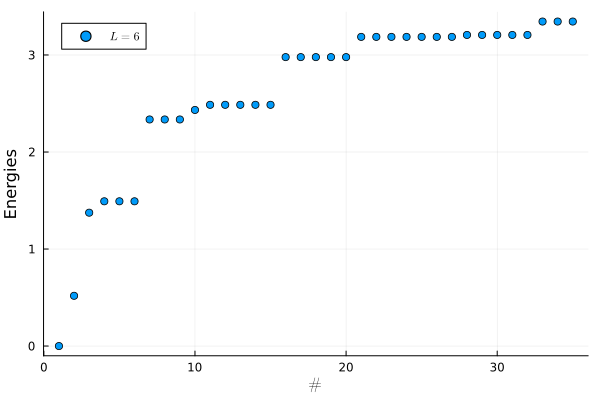

In [27]:
scatter(vals[1:35], label = L"L=6")
xlabel!(L"\#")
ylabel!("Energies")    

#### Magnetization order parameter:

In [22]:
####################################### Physical system properties #######################################
mz = 0
Nh = 20
parityZ2 = 1
lengthList = Int[4,5,6,7]

###################################### Interactions/couplings value ######################################
v00= 4.75
v11 = 1
h = range(0.0,4,Nh)
mList = []
m2List = []
m4List = []

################################### Getting the magnetization ###################################
for length in lengthList
    println("############################ Length starts L=$length ############################")
    N = length 
    m = zeros(Real, Nh)
    m2 = zeros(Real, Nh)
    m4 = zeros(Real, Nh)
    (stateList0,basisMap0) = makeBasisMapMz(N,length,mz)
    i=1
    for hz in h
        rot = 1
        (stateListPos, basisMapPos) = basisZ2rotY(stateList0, length, N, parityZ2, rot) 
        HL = HIsingZ2Rot(N=N,half_L=length,parityZ2=parityZ2,rot=rot,h=hz,v00=v00,v11=v11,stateList=stateListPos,basisMap=basisMapPos)
        @time Hsparse = Hermitian(makeH(HL))
        #if length >= 8
        #    println("hamiltonian constructed")
        #end
        (valsPos,vecsPos) = eigs(Hsparse, nev=1, which=:SR)
        
        rot = -1
        (stateListNeg, basisMapNeg) = basisZ2rotY(stateList0, length, N, parityZ2, rot) 
        HL = HIsingZ2Rot(N=N,half_L=length,parityZ2=parityZ2,rot=rot,h=hz,v00=v00,v11=v11,stateList=stateListNeg,basisMap=basisMapNeg)
        @time Hsparse = Hermitian(makeH(HL))
        #if length >= 8
        #    println("hamiltonian constructed")
        #end
        (valsNeg,vecsNeg) = eigs(Hsparse, nev=1, which=:SR)
        
        if valsPos[1] > valsNeg[1]
            gs_state = vecsNeg[:,1]
            (m[i],m2[i],m4[i])=computeMagnetization(gs_state,stateListNeg,basisMapNeg,length)
            i+=1
        elseif valsNeg[1] > valsPos[1]
            gs_state = vecsPos[:,1]
            (m[i],m2[i],m4[i])=computeMagnetization(gs_state,stateListPos,basisMapPos,length)
            i+=1
        end
    end
    println("###########################################################################")
    push!(mList, m)
    push!(m2List, m2)
    push!(m4List, m4)
end

############################ Length starts L=4 ############################
  0.003676 seconds (37.22 k allocations: 772.109 KiB)
  0.000955 seconds (9.38 k allocations: 199.078 KiB)
  0.003763 seconds (37.33 k allocations: 782.766 KiB)
  0.002736 seconds (9.41 k allocations: 201.578 KiB)
  0.006182 seconds (37.33 k allocations: 782.766 KiB)
  0.000979 seconds (9.41 k allocations: 201.578 KiB)
  0.004443 seconds (37.33 k allocations: 782.766 KiB)
  0.000823 seconds (9.41 k allocations: 201.578 KiB)
  0.008540 seconds (37.33 k allocations: 782.766 KiB)
  0.000992 seconds (9.41 k allocations: 201.578 KiB)
  0.005450 seconds (37.33 k allocations: 782.766 KiB)
  0.001565 seconds (9.41 k allocations: 201.578 KiB)
  0.004287 seconds (37.33 k allocations: 782.766 KiB)
  0.000963 seconds (9.41 k allocations: 201.578 KiB)
  0.004757 seconds (37.33 k allocations: 782.766 KiB)
  0.000962 seconds (9.41 k allocations: 201.578 KiB)
  0.005567 seconds (37.33 k allocations: 782.766 KiB)
  0.001509 sec

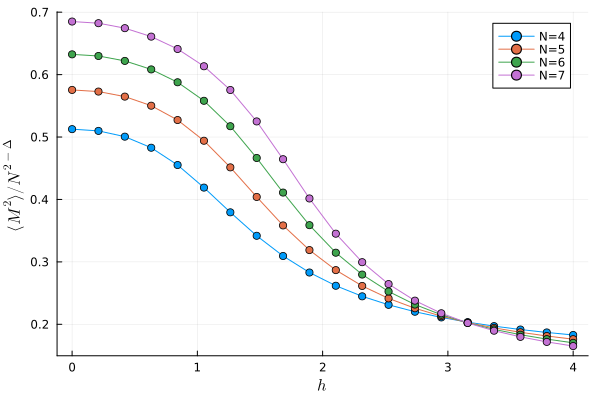

In [24]:
plot(h, [(m2List[1])./4^(2-0.518),(m2List[2])./5^(2-0.518),(m2List[3])./6^(2-0.518), (m2List[4])./7^(2-0.518)], labels = ["N=4" "N=5" "N=6" "N=7" "N=8"], marker= (:circle))
xlabel!(L"h")
ylabel!(L"\langle M^2 \rangle/N^{2-\Delta}")

### Ising CFT: old alt way

In [41]:
############################################## Properties of the system ################################################
length = 6                            # Physical length of the system
N = length                            # Filling
L = 2*length                          # String length (twice because is spinful electrons)
mz = 0                                # TWICE the U(1) value of the SO(3) from the sphere: mz = \sum 2*m c_m^\dagger c_m 
parityZ2 = 1                          # Ising Z2 
rot = 1                               # Pi rotation around the y-axis
spin = (length-1)/2

################################### Properties of the system that won't change #########################################
mz = 0                                                  # U(1) of the SO(3) from the sphere. mz = \sum m c_m^\dagger c_m
hz = 3.16                                               # Magnetic field h
v0 = 4.75
v1 = 1
g00 = 2*pi*((4*spin+1)*v0+(4*spin-1)*v1)/(2*spin+1)     # g0 term from the onsite term n^0 n^0
g11 = 2*pi*(4*spin-1)*v1/spin                           # g1 term from the onsite term n^0 n^0
J00 = v00                                               # J0 term from the FM term n^z n^z
J11 = v11;                                              # J1 term from the FM term n^z n^z


#################################################### Basis ##############################################################
#(stateList0,basisMap0) = makeBasisMap(N,L)                                     # U(1) of particle number
(stateList0,basisMap0) = makeBasisMapMz(N,length,mz)                           # U(1) of particle number and Mz
#(stateList, basisMap) = basisZ2(stateList0, parityZ2)                          # Refines the list into Z2 Ising
#(stateList, basisMap) = basisZ2rotY(stateList0, length, N, parityZ2, rot)      # Refines into Z2 Ising and Pi rotations-Y

################################ Packing all the information into a single structure ####################################
HL = HIsingAlt(N=N,half_L=length,h=hz,g00=g00,g11=g11,stateList=stateList0,basisMap=basisMap0)

################################ Creating the Hamiltonian and obtaining the spectrum ####################################
@time Hsparse = Hermitian(makeH(HL))                              # Creating Hamiltonian and Hermitian
#@time (vals, vecs) = eigs(Hsparse, nev=1, which=:SR)              # Lowest eigenstates and eigenvalues
@time (vals1, vecs) = eigen(collect(Hsparse))                      # Full spectrum
#gs_state = vecs[:,1];

#vals1 = vals1 .- vals1[1]
#vals1 = vals1./(vals1[2]/0.518);
vals1;

  1.150970 seconds (6.48 M allocations: 129.317 MiB, 19.65% gc time)
  0.010155 seconds (18 allocations: 494.922 KiB)


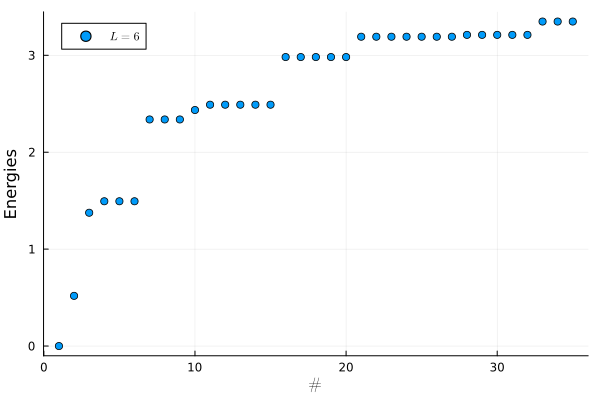

In [23]:
scatter(vals1[1:35], label = L"L=6")
xlabel!(L"\#")
ylabel!("Energies")    

#### Magnetization order parameter:

In [46]:
####################################### Physical system properties #######################################
mz = 0
Nh = 20
lengthList = Int[4,5,6,7]

###################################### Interactions/couplings value ######################################
v0 = 4.75
v1 = 1
h = range(0.0,4,Nh)
mList = []
m2List = []
m4List = []

################################### Getting the magnetization ###################################
for length in lengthList
    println("############################ Length starts L=$length ############################")
    spin = (length-1)/2
    g00= 2*pi*((4*spin+1)*v0+(4*spin-1)*v1)/(2*spin+1)
    g11 = 2*pi*(4*spin-1)*v1/spin
    J00 = v00
    J11 = v11
    N = length 
    m = zeros(Real, Nh)
    m2 = zeros(Real, Nh)
    m4 = zeros(Real, Nh)
    (stateList0,basisMap0) = makeBasisMapMz(N,length,mz)
    i=1
    for hz in h
        HL = HIsingAlt(N=N,half_L=length,h=hz,g00=g00,g11=g11,stateList=stateList0,basisMap=basisMap0)
        Hsparse = Hermitian(makeH(HL))  
        (vals, vecs) = eigs(Hsparse, nev=1, which=:SR)
        gs_state = vecs[:,1]
        (m[i],m2[i],m4[i])=computeMagnetization(gs_state,stateList0,basisMap0,length)
        i+=1
    end
    println("###########################################################################")
    push!(mList, m)
    push!(m2List, m2)
    push!(m4List, m4)
end

############################ Length starts L=4 ############################
###########################################################################
############################ Length starts L=5 ############################
###########################################################################
############################ Length starts L=6 ############################
###########################################################################
############################ Length starts L=7 ############################
###########################################################################


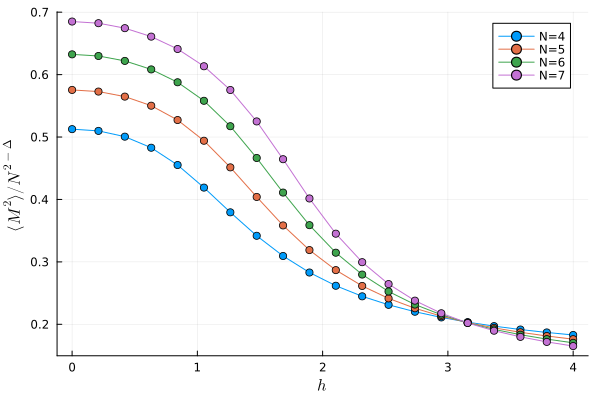

In [47]:
plot(h, [(m2List[1])./4^(2-0.518), (m2List[2])./5^(2-0.518),(m2List[3])./6^(2-0.518), (m2List[4])./7^(2-0.518)], labels = ["N=4" "N=5" "N=6" "N=7" "N=8"], marker= (:circle))
xlabel!(L"h")
ylabel!(L"\langle M^2 \rangle/N^{2-\Delta}")

## Ising CFT: single band of spherical harmonics

In [97]:
############################################## Properties of the system ################################################
lorb = 1                              # Number of orbitals
length = 2*lorb+1                     # Physical length of the system
N = length                            # Filling
L = 2*length                          # String length (twice because is spin-1/2 electrons)
mz = 0                                # TWICE the U(1) value of the SO(3) from the sphere: mz = \sum 2*m c_m^\dagger c_m 
parityZ2 = 1                         # Ising Z2 
rot = 1                              # Pi rotation around the y-axis
spin = lorb

################################### Properties of the system that won't change #########################################
mz = 0                                                  # U(1) of the SO(3) from the sphere. mz = \sum m c_m^\dagger c_m
hz = 100.0                                               # Magnetic field h
v0 = 4.75                                               # V0 pseudopotential term from the onsite term n^0 n^0 - n^z n^z
v1 = 1                                                  # V1 pseudopotential term from the onsite term n^0 n^0 - n^z n^z
g00 = 2*pi*((4*spin+1)*v0+(4*spin-1)*v1)/(2*spin+1)     # g0 term from the U_l potential
g11 = 2*pi*(4*spin-1)*v1/spin                           # g1 term from the U_l potential           

#################################################### Basis ##############################################################
#(stateList0,basisMap0) = makeBasisMap(N,L)                                     # U(1) of particle number
(stateList0,basisMap0) = makeBasisMapMz(N,length,mz)                           # U(1) of particle number and Mz
#(stateList, basisMap) = basisZ2(stateList0, parityZ2)                          # Refines the list into Z2 Ising
#(stateList, basisMap) = basisZ2rotY(stateList0, length, N, parityZ2, rot)      # Refines into Z2 Ising and Pi rotations-Y

################################ Packing all the information into a single structure ####################################
HL = HNewIsing(N=N,half_L=length,radius=N,h=hz,g00=g00,g11=g11,stateList=stateList0,basisMap=basisMap0)
#HL = HNewIsingZ2(N=N,half_L=length,radius=sqrt(N),parityZ2=parityZ2,h=hz,g00=g00,g11=g11,stateList=stateList,basisMap=basisMap)
#HL = HNewIsingZ2Rot(N=N,half_L=length,radius=sqrt(N),parityZ2=parityZ2,rot=rot,h=hz,g00=g00,g11=g11,stateList=stateList,basisMap=basisMap)

################################ Creating the Hamiltonian and obtaining the spectrum ####################################
@time Hsparse = Hermitian(makeH(HL))                              # Creating Hamiltonian and Hermitian
#@time (vals, vecs) = eigs(Hsparse, nev=1, which=:SR)              # Lowest eigenstates and eigenvalues
(vals, vecs) = eigen(collect(Hsparse))                      # Full spectrum
#gs_state = vecs[:,1];
vals = vals .- vals[1]
vals = vals./(vals[2]/0.518)

vals;

  0.000744 seconds (15.48 k allocations: 249.703 KiB)


So it seems that if $R=N$ there's the nice collapse. The problem is that the spectrum looks like trash. There's no indication of being conformal at all. It seems like a lot of singlets are being prioritize. The only way to check if there's a special point is by using YC integer spacing to be honest. But to do this I need to construct the $SO(3)$ generators in this basis.

Also, for $R=N$, we do see the two phases. There's the paramagnet in large $h$ and the SSB phase in small $h$. This was checked for even and odd system sizes.

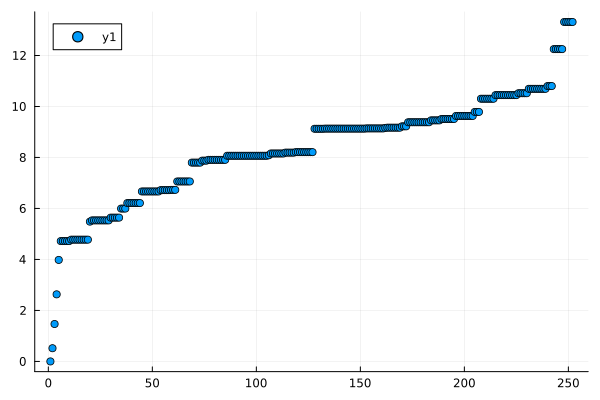

In [121]:
scatter(vals)

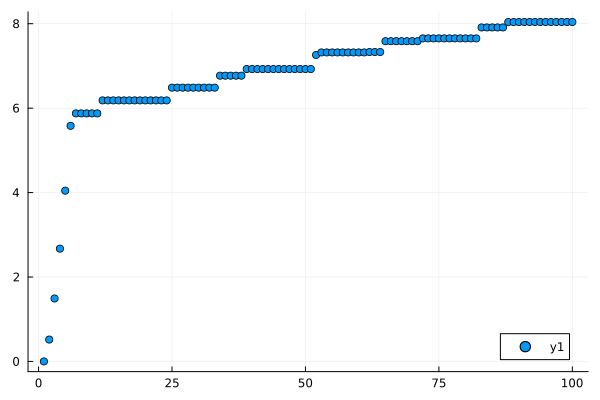

In [123]:
scatter(vals[1:100])

### Magnetization order parameter:

#### Some tries for different N scalings:

In [109]:
####################################### Physical system properties #######################################
mz = 0
Nh = 15
parityZ2 = 1
lorbList = Int[1,2,3]

###################################### Interactions/couplings value ######################################
v0 = 4.75                                               # V0 pseudopotential term from the onsite term n^0 n^0 - n^z n^z
v1 = 1                                                  # V1 pseudopotential term from the onsite term n^0 n^0 - n^z n^z 

h = [range(1.5,10,Nh),range(0.01,7,Nh),range(0.01,4,Nh),range(0.001,1.5,Nh)]
alphaList = [1/2, 3/4, 1, 5/4]

mListAlpha = []
m2ListAlpha = []
m4ListAlpha = []

j = 1
for alpha in alphaList
    
    mList = []
    m2List = []
    m4List = []

    ################################### Getting the magnetization ###################################
    for lorb in lorbList
        spin = lorb
        g00 = 2*pi*((4*spin+1)*v0+(4*spin-1)*v1)/(2*spin+1)     # g0 term from the U_l potential
        g11 = 2*pi*(4*spin-1)*v1/spin                           # g1 term from the U_l potential 
        length = 2*lorb+1                  
        println("############################ Length starts L=$length ############################")
        N = length 
        m = zeros(Real, Nh)
        m2 = zeros(Real, Nh)
        m4 = zeros(Real, Nh)
        (stateList0,basisMap0) = makeBasisMapMz(N,length,mz)
        i=1
        println(j)
        for hz in h[j]
            rot = 1
            (stateListPos, basisMapPos) = basisZ2rotY(stateList0, length, N, parityZ2, rot) 
            HL = HNewIsingZ2Rot(N=N,half_L=length,radius=N^(alpha),parityZ2=parityZ2,rot=rot,h=hz,g00=g00,g11=g11,stateList=stateListPos,basisMap=basisMapPos)
            @time Hsparse = Hermitian(makeH(HL))
            if size(stateListPos,1) == 1 
                (valsPos,vecsPos) = eigen(collect(Hsparse))
            elseif (size(stateListPos,1) > 1)
                (valsPos,vecsPos) = eigs(Hsparse, nev=1, which=:SR)
            else 
                valsPos = [10000]
            end
        
            rot = -1
            (stateListNeg, basisMapNeg) = basisZ2rotY(stateList0, length, N, parityZ2, rot) 
            HL = HNewIsingZ2Rot(N=N,half_L=length,radius=N^(alpha),parityZ2=parityZ2,rot=rot,h=hz,g00=g00,g11=g11,stateList=stateListNeg,basisMap=basisMapNeg)
            @time Hsparse = Hermitian(makeH(HL))
            if size(stateListNeg,1) == 1 
                (valsNeg,vecsNeg) = eigen(collect(Hsparse))
            elseif (size(stateListNeg,1) > 1)
                (valsNeg,vecsNeg) = eigs(Hsparse, nev=1, which=:SR)
            else 
                valsNeg = [10000]
            end
        
            if valsPos[1] > valsNeg[1]
                gs_state = vecsNeg[:,1]
                (m[i],m2[i],m4[i])=computeMagnetization(gs_state,stateListNeg,basisMapNeg,length)
                i+=1
            elseif valsNeg[1] > valsPos[1]
                gs_state = vecsPos[:,1]
                (m[i],m2[i],m4[i])=computeMagnetization(gs_state,stateListPos,basisMapPos,length)
                i+=1
            end
        end
        println("###########################################################################")
        push!(mList, m)
        push!(m2List, m2)
        push!(m4List, m4)
    end
    j+=1
    push!(mListAlpha,mList)
    push!(m2ListAlpha, m2List)
    push!(m4ListAlpha, m4List)
end

############################ Length starts L=3 ############################
1
  0.005138 seconds (2.00 k allocations: 35.859 KiB)
  0.001499 seconds (5.92 k allocations: 102.484 KiB)
  0.000765 seconds (2.00 k allocations: 35.859 KiB)
  0.001268 seconds (5.92 k allocations: 102.484 KiB)
  0.000202 seconds (2.00 k allocations: 35.859 KiB)
  0.001323 seconds (5.92 k allocations: 102.484 KiB)
  0.000518 seconds (2.00 k allocations: 35.859 KiB)
  0.001396 seconds (5.92 k allocations: 102.484 KiB)
  0.000324 seconds (2.00 k allocations: 35.859 KiB)
  0.001349 seconds (5.92 k allocations: 102.484 KiB)
  0.000575 seconds (2.00 k allocations: 35.859 KiB)
  0.001148 seconds (5.92 k allocations: 102.484 KiB)
  0.000375 seconds (2.00 k allocations: 35.859 KiB)
  0.001410 seconds (5.92 k allocations: 102.484 KiB)
  0.000283 seconds (2.00 k allocations: 35.859 KiB)
  0.000889 seconds (5.92 k allocations: 102.484 KiB)
  0.000371 seconds (2.00 k allocations: 35.859 KiB)
  0.001460 seconds (5.92 k all

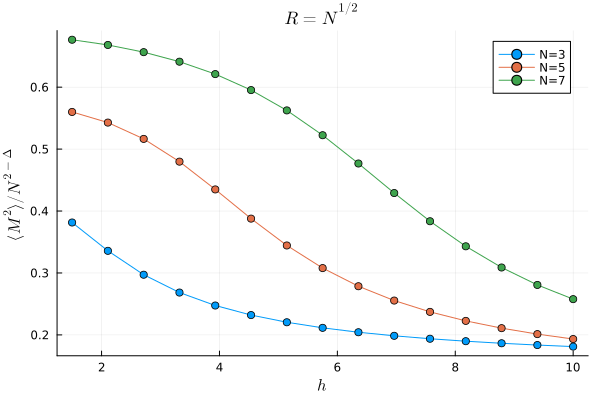

In [110]:
plot(h[1], [(m2ListAlpha[1][1])./3^(2-0.518), (m2ListAlpha[1][2])./5^(2-0.518), (m2ListAlpha[1][3])./7^(2-0.518)], labels = ["N=3" "N=5" "N=7" "N=11"], marker= (:circle))
xlabel!(L"h")
ylabel!(L"\langle M^2 \rangle/N^{2-\Delta}")
title!(L"R=N^{1/2}", titlefontsize = 12)

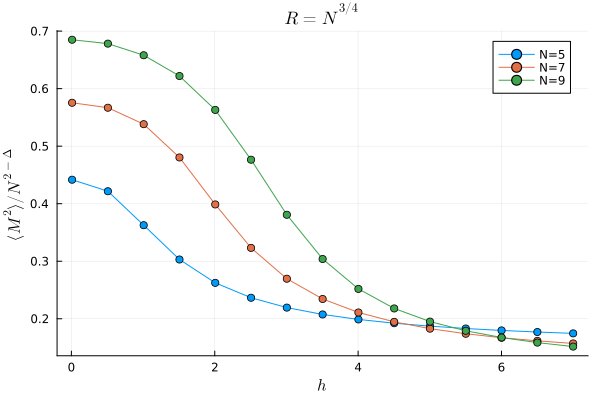

In [111]:
plot(h[2], [(m2ListAlpha[2][1])./3^(2-0.518), (m2ListAlpha[2][2])./5^(2-0.518), (m2ListAlpha[2][3])./7^(2-0.518)], labels = ["N=5" "N=7" "N=9" "N=11"], marker= (:circle))
xlabel!(L"h")
ylabel!(L"\langle M^2 \rangle/N^{2-\Delta}")
title!(L"R=N^{3/4}", titlefontsize = 12)

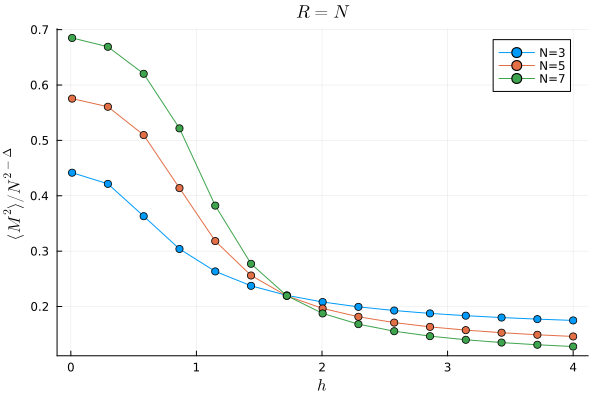

In [112]:
plot(h[3], [(m2ListAlpha[3][1])./3^(2-0.518), (m2ListAlpha[3][2])./5^(2-0.518), (m2ListAlpha[3][3])./7^(2-0.518)], labels = ["N=3" "N=5" "N=7" "N=9"], marker= (:circle))
xlabel!(L"h")
ylabel!(L"\langle M^2 \rangle/N^{2-\Delta}")
title!(L"R=N", titlefontsize = 12)

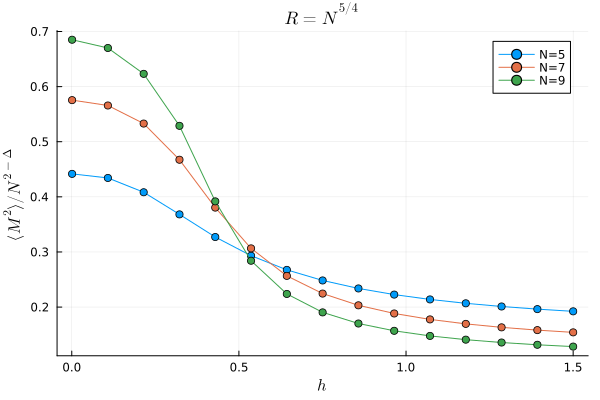

In [113]:
plot(h[4], [(m2ListAlpha[4][1])./3^(2-0.518), (m2ListAlpha[4][2])./5^(2-0.518), (m2ListAlpha[4][3])./7^(2-0.518)], labels = ["N=5" "N=7" "N=9" "N=11"], marker= (:circle))
xlabel!(L"h")
ylabel!(L"\langle M^2 \rangle/N^{2-\Delta}")
title!(L"R=N^{5/4}", titlefontsize = 12)

#### Fix $\alpha=\frac{1}{2}$ and move $\Delta$:

In [17]:
####################################### Physical system properties #######################################
mz = 0
Nh = 100
parityZ2 = 1
lorbList = Int[1,2,3]

###################################### Interactions/couplings value ######################################
v0 = 4.75                                               # V0 pseudopotential term from the onsite term n^0 n^0 - n^z n^z
v1 = 1                                                  # V1 pseudopotential term from the onsite term n^0 n^0 - n^z n^z 

hList = range(0.01, 100,Nh)
alpha = 1/2

mList = []
m2List = []
m4List = []

################################### Getting the magnetization ###################################
for lorb in lorbList
    spin = lorb
    g00 = 2*pi*((4*spin+1)*v0+(4*spin-1)*v1)/(2*spin+1)     # g0 term from the U_l potential
    g11 = 2*pi*(4*spin-1)*v1/spin                           # g1 term from the U_l potential 
    length = 2*lorb+1                  
    println("############################ Length starts L=$length ############################")
    N = length 
    m = zeros(Real, Nh)
    m2 = zeros(Real, Nh)
    m4 = zeros(Real, Nh)
    (stateList0,basisMap0) = makeBasisMapMz(N,length,mz)
    i=1

    for hz in hList
        rot = 1
        (stateListPos, basisMapPos) = basisZ2rotY(stateList0, length, N, parityZ2, rot) 
        HL = HNewIsingZ2Rot(N=N,half_L=length,radius=N^(alpha),parityZ2=parityZ2,rot=rot,h=hz,g00=g00,g11=g11,stateList=stateListPos,basisMap=basisMapPos)
        @time Hsparse = Hermitian(makeH(HL))
        if size(stateListPos,1) == 1 
            (valsPos,vecsPos) = eigen(collect(Hsparse))
        elseif (size(stateListPos,1) > 1)
            (valsPos,vecsPos) = eigs(Hsparse, nev=1, which=:SR)
        else 
            valsPos = [10000]
        end
        
        rot = -1
        (stateListNeg, basisMapNeg) = basisZ2rotY(stateList0, length, N, parityZ2, rot) 
        HL = HNewIsingZ2Rot(N=N,half_L=length,radius=N^(alpha),parityZ2=parityZ2,rot=rot,h=hz,g00=g00,g11=g11,stateList=stateListNeg,basisMap=basisMapNeg)
        @time Hsparse = Hermitian(makeH(HL))
        if size(stateListNeg,1) == 1 
            (valsNeg,vecsNeg) = eigen(collect(Hsparse))
        elseif (size(stateListNeg,1) > 1)
            (valsNeg,vecsNeg) = eigs(Hsparse, nev=1, which=:SR)
        else 
            valsNeg = [10000]
        end
        
        if valsPos[1] > valsNeg[1]
            gs_state = vecsNeg[:,1]
            (m[i],m2[i],m4[i])=computeMagnetization(gs_state,stateListNeg,basisMapNeg,length)
            i+=1
        elseif valsNeg[1] > valsPos[1]
            gs_state = vecsPos[:,1]
            (m[i],m2[i],m4[i])=computeMagnetization(gs_state,stateListPos,basisMapPos,length)
            i+=1
        end
    end
    println("###########################################################################")
    push!(mList, m)
    push!(m2List, m2)
    push!(m4List, m4)
end

############################ Length starts L=3 ############################
  0.004139 seconds (2.00 k allocations: 35.859 KiB)
  0.001140 seconds (5.92 k allocations: 102.484 KiB)
  0.000159 seconds (2.00 k allocations: 35.859 KiB)
  0.000359 seconds (5.92 k allocations: 102.484 KiB)
  0.000155 seconds (2.00 k allocations: 35.859 KiB)
  0.000454 seconds (5.92 k allocations: 102.484 KiB)
  0.000143 seconds (2.00 k allocations: 35.859 KiB)
  0.000473 seconds (5.92 k allocations: 102.484 KiB)
  0.000285 seconds (2.00 k allocations: 35.859 KiB)
  0.000444 seconds (5.92 k allocations: 102.484 KiB)
  0.000154 seconds (2.00 k allocations: 35.859 KiB)
  0.000650 seconds (5.92 k allocations: 102.484 KiB)
  0.000170 seconds (2.00 k allocations: 35.859 KiB)
  0.000426 seconds (5.92 k allocations: 102.484 KiB)
  0.000153 seconds (2.00 k allocations: 35.859 KiB)
  0.000497 seconds (5.92 k allocations: 102.484 KiB)
  0.000181 seconds (2.00 k allocations: 35.859 KiB)
  0.000485 seconds (5.92 k alloc

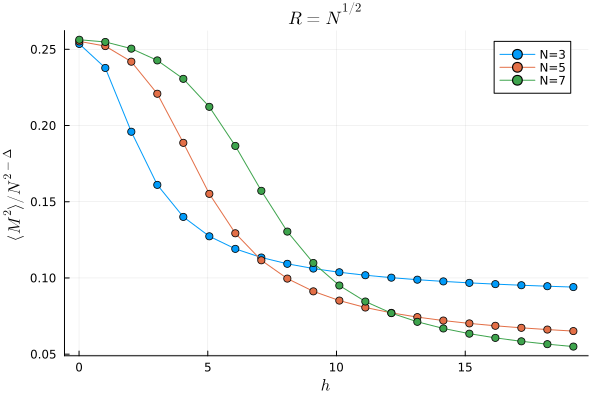

In [40]:
delta = 0.01275
cutdown = 1
cutoff = 20
plot(hList[cutdown:cutoff], [(m2List[1][cutdown:cutoff])./3^(2-delta), (m2List[2][cutdown:cutoff])./5^(2-delta), (m2List[3][cutdown:cutoff])./7^(2-delta)], labels = ["N=3" "N=5" "N=7" "N=11"], marker= (:circle))
xlabel!(L"h")
ylabel!(L"\langle M^2 \rangle/N^{2-\Delta}")
title!(L"R=N^{1/2}", titlefontsize = 12)

There's no possible value at which makes the crossing: 
20 31
11 19
9  14
8  13
7  12
